In [1]:
import glacierml as gl
from tqdm import tqdm
import scipy.stats as st
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance
pd.set_option('display.max_columns', None)

2024-01-09 18:03:36.327753: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 18:03:36.370707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 18:03:37.056873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#### normalize data for plotting ####
norm = False

def normx(x, norm = True):
    if norm == False:
        z = x
    elif norm == True:
        z = (x - np.min(x)) / (np.max(x) - np.min(x)) * 100
    return z

In [3]:
df = gl.coregister_data('4')
df = df.drop(df[df['RGIId'].duplicated(keep = False) == True].index)
df = df.sample(frac = 1,random_state = 0)
df = df.reset_index().drop('index', axis = 1)

#### Add mean thickness estimates to dataset ####
# model_path = '/data/fast1/glacierml/models/LOO/'
model_path = os.path.join(
    '/data/fast1/glacierml/models/LOO/' ,'rgi_est_raw.pkl'
)
# RGI = pd.read_pickle(model_path + 'rgi_est_raw.pkl') ascendingThickness_rgi_est_raw_.pkl
RGI = pd.read_pickle(model_path) 
rgi_list = list(df)[:-1]
rgi_list.append('RGIId')
old_index = df.index.to_list()
df = pd.merge(df,RGI,how = 'inner', on = rgi_list)

#### Add Farinotti mean thickness estimates ####
ref_pth = '/data/fast1/glacierml/data/reference_thicknesses/'
ref = pd.DataFrame()
for file in os.listdir(ref_pth):
    if 'Farinotti' in file:
        file_reader = pd.read_csv('reference_thicknesses/' + file)
        ref = pd.concat([ref, file_reader], ignore_index = True) 
ref = ref.rename(columns = {
     'Farinotti Mean Thickness':'FMT',
})
ref = ref[[
     'FMT',
     'RGIId',
]]

df = pd.merge(df, ref, how = 'inner', on = 'RGIId')
cols = df.sort_values('Thickness', ascending = True).index
df = df.sort_values('Thickness', ascending = True)

Text(0, 0.5, 'Left-Out-Thickness Model')

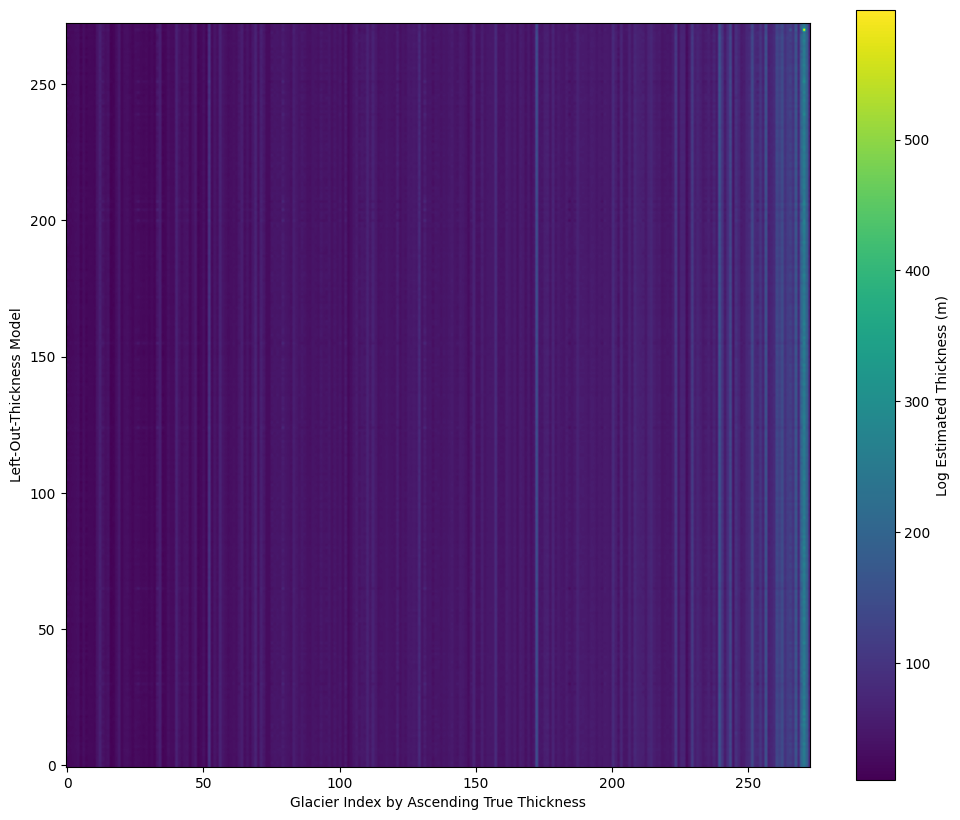

In [4]:
### Visualize the dataset ####

x = (df[cols].T)
plt.figure(figsize = (12,10))
plt.imshow(
    x, cmap = 'viridis',vmin=np.min(x),vmax=np.max(x)
)
plt.gca().invert_yaxis()

plt.colorbar(label = 'Log Estimated Thickness (m)')
plt.xlabel('Glacier Index by Ascending True Thickness')
plt.ylabel('Left-Out-Thickness Model')
# plt.xlabel

Text(0, 0.5, 'Left-Out-Thickness Model')

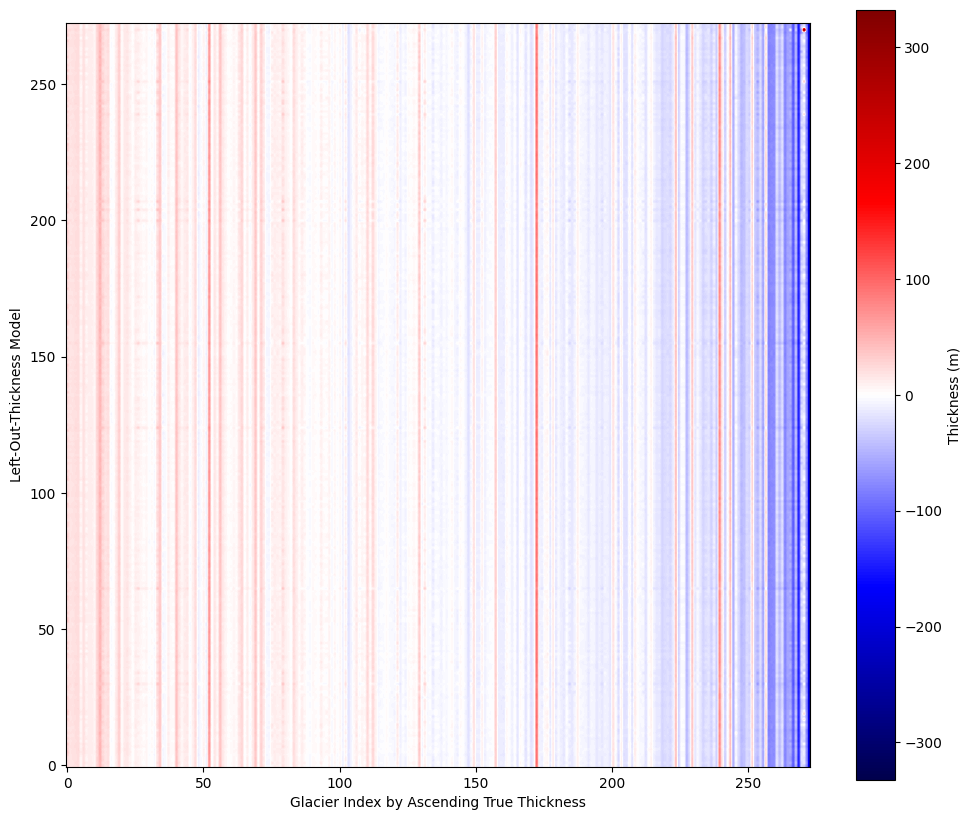

In [5]:
### Visualize the dataset ####
r = (df[cols].T - df['Thickness'])
plt.figure(figsize = (12,10))
plt.imshow(
    r, cmap = 'seismic',vmin=-(np.max(abs(r))),vmax=np.max(abs(r))
)
plt.gca().invert_yaxis()

plt.colorbar(label = 'Thickness (m)')
plt.xlabel('Glacier Index by Ascending True Thickness')
plt.ylabel('Left-Out-Thickness Model')
# plt.xlabel

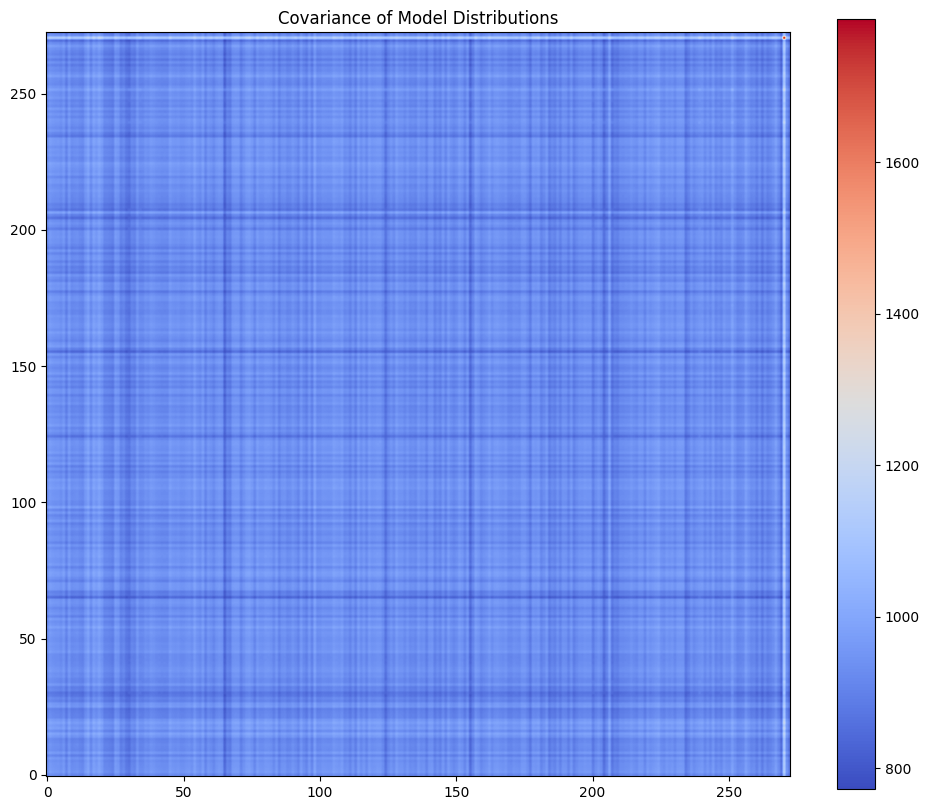

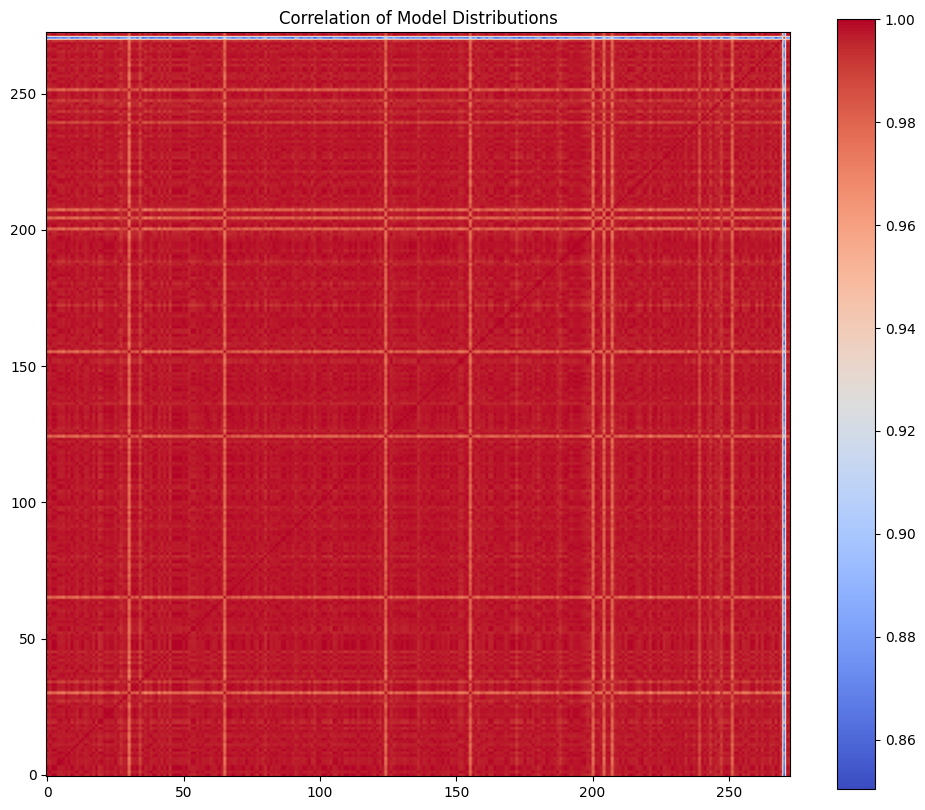

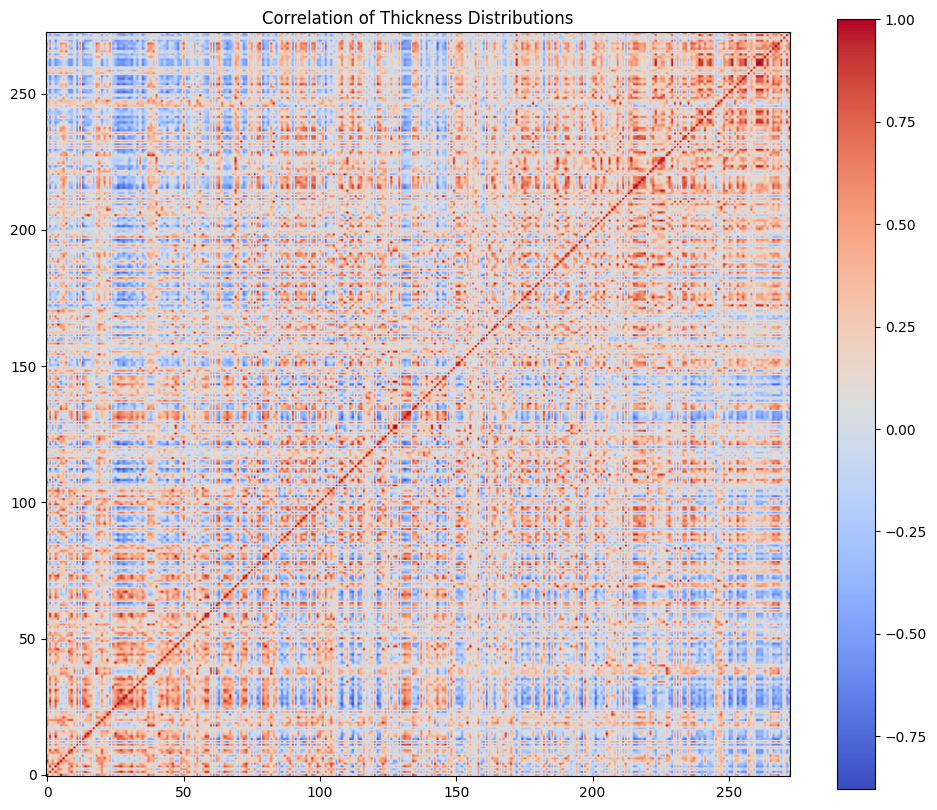

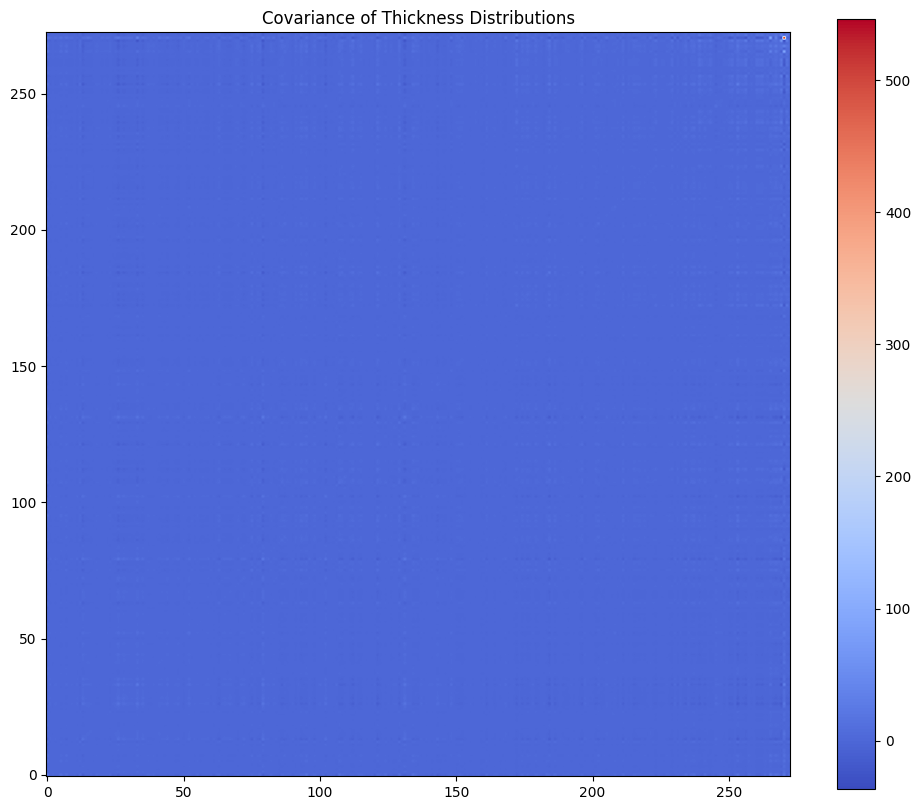

In [6]:
#Each row of m represents a variable
#each column a single observation of all those variables.
#treat each model as a variable
cov1 = np.cov(df[cols].T)
cor1 = np.corrcoef(df[cols].T)

x = cov1

fig = plt.subplots(figsize = (12,10))
plt.imshow(
    x,cmap = 'coolwarm',vmin=np.min(x),vmax=np.max(x)
)
plt.gca().invert_yaxis()

plt.title('Covariance of Model Distributions')
plt.colorbar()

x = cor1

fig = plt.subplots(figsize = (12,10))
plt.imshow(
    x,cmap = 'coolwarm',vmin=np.min(x),vmax=np.max(x)
)
plt.gca().invert_yaxis()

plt.title('Correlation of Model Distributions')
plt.colorbar()

#treat each glacier as a variable
cov2 = np.cov(df[cols])
cor2 = np.corrcoef(df[cols])
x = cor2

plt.figure(figsize=(12, 10))
plt.imshow(
    x, cmap = 'coolwarm',vmin=x.min(),vmax = x.max()
)
plt.title('Correlation of Thickness Distributions')
plt.gca().invert_yaxis()

plt.colorbar()
x = cov2

plt.figure(figsize=(12, 10))
plt.imshow(
    x, cmap = 'coolwarm',vmin=x.min(),vmax = x.max()
)
plt.gca().invert_yaxis()

plt.title('Covariance of Thickness Distributions')

plt.colorbar()

Text(0, 0.5, 'Left-Out-Thickness Model Estimate')

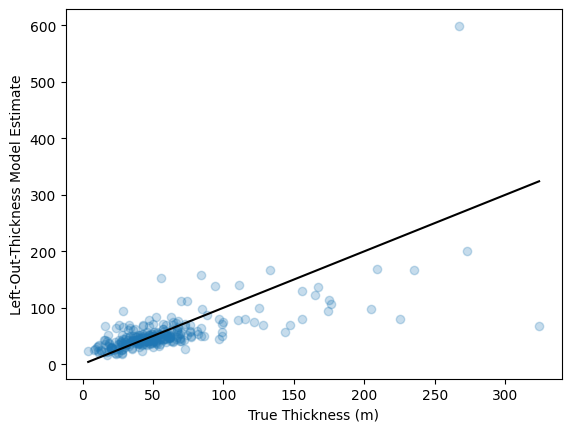

In [7]:
#### Left-Out-Thickness Model Estimates ####
mods = pd.DataFrame(columns = ['LOO','True'])
mods['LOO'] = pd.Series(np.diag(df[cols]))
mods['True'] = (df['Thickness'].reset_index().drop('index', axis = 1))

x = mods['True']
y = mods['LOO']
plt.scatter(
    x,y,alpha = 0.25
)
plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    'k-'
)
plt.xlabel('True Thickness (m)')
plt.ylabel('Left-Out-Thickness Model Estimate')

In [48]:
mods[mods['LOO'] == mods['LOO'].max()]

LOO   True
270  599.205688  267.0

In [8]:
#### Calculate 95% confidence intervals ####
X = np.mean(df[cols], axis = 1)
se = np.std(df[cols], axis = 1) / np.sqrt(len(cols))

df['LCI'] = X - (1.96 * se)
df['UCI'] = X + (1.96 * se)

lb = df['LCI'] / 1e3 * df['Area'] / 1e3
ub = df['UCI'] / 1e3 * df['Area'] / 1e3

/tmp/ipykernel_3824550/3958088393.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['LCI'] = X - (1.96 * se)
/tmp/ipykernel_3824550/3958088393.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['UCI'] = X + (1.96 * se)


In [9]:
# Calculate 95% confidence intervals ####
X = np.mean(df[cols], axis = 1)
se = np.std(df[cols], axis = 1) / np.sqrt(len(cols))

df['LCI'] = X - (1.96 * se)
df['UCI'] = X + (1.96 * se)

lb = df['LCI'] / 1e3 * df['Area'] / 1e3
ub = df['UCI'] / 1e3 * df['Area'] / 1e3

Text(0.5, 1.0, 'Leave-One-Out X-val 95% CI')

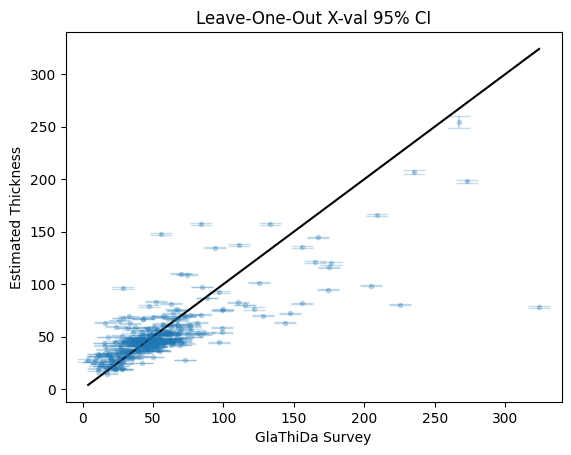

In [10]:
x = df['Thickness']
# y = np.mean(dfci, axis = 1)
# y = df['we']
y = np.mean(df[cols],axis = 1)
plt.errorbar(
    x,y,yerr = df['UCI'] - df['LCI'],
        alpha = 0.25,
#     label = 'Estimates $\hat{\mu}(x)$',
    linestyle = 'None',
    marker = '.',
    capsize = 8,
    color = '#1f77b4',
)

plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    '-k'
)

plt.ylabel('Estimated Thickness')
plt.xlabel('GlaThiDa Survey')
plt.title('Leave-One-Out X-val 95% CI')
# plt.xscale('log')
# plt.yscale('log')

In [53]:
df[df['Thickness'] == 267]

RGIId   CenLat   CenLon  Slope  Zmin  Zmed  Zmax      Area   
115  RGI60-04.06187  70.0214 -73.0575    3.6   403   860  1117  2771.412  \

     Aspect   Lmax  Thickness         GLIMSId   BgnDate   EndDate  O1Region   
115      51  29873      267.0  G286943E70021N  20020802  20020905         4  \

     O2Region  Status  Connect  Form  TermType  Surging  Linkages   
115         5       0        0     1         0        2         1  \

                                  Name region           0           1   
115  Barnes Ice Cap South Dome N Slope     04  251.526962  253.097641  \

              2           3           4           5           6           7   
115  246.619202  239.754395  248.156555  251.379425  248.960846  252.035995  \

              8           9         10          11          12         13   
115  239.124969  245.301437  246.57843  252.343887  253.038223  250.46814  \

             14         15          16          17          18          19   
115  247.121719  249.01973  248.763763  245.713943  250.512878  251.973129  \

             20          21          22          23          24          25   
115  276.744293  249.286377  256.641357  251.195206  254.802231  244.935883  \

             26         27          28          29          30          31   
115  254.269638  274.60965  275.880341  283.513153  270.569916  248.545883  \

             32          33          34          35          36          37   
115  270.564697  257.339111  253.310135  270.312805  247.378693  269.997894  \

             38         39         40          41          42          43   
115  247.980301  247.11734  269.36908  261.082306  259.735657  260.574585  \

             44          45          46          47          48          49   
115  250.576721  262.799561  273.215363  289.577545  282.946167  272.540222  \

             50          51          52          53          54        55   
115  251.788681  256.487976  262.165894  260.736694  266.756805  268.4487  \

             56          57          58          59          60          61   
115  261.081543  265.747772  253.091415  249.043335  260.672974  252.692154  \

             62          63          64          65          66          67   
115  246.259018  271.130035  250.776917  245.137817  247.725311  239.721054  \

            68          69          70          71         72          73   
115  273.17514  248.675934  277.954498  243.667816  246.77742  242.026688  \

             74          75         76         77          78          79   
115  253.167801  255.757294  254.81723  271.84375  248.944733  261.159607  \

             80          81          82          83          84         85   
115  258.770416  255.674973  254.089996  249.821304  241.875732  251.09874  \

             86          87          88          89          90          91   
115  255.764755  269.758362  250.909698  245.535645  244.837234  270.241486  \

             92          93          94          95         96          97   
115  264.262787  240.890091  254.551956  247.570679  255.00766  261.379303  \

             98         99        100         101         102         103   
115  252.108383  250.44577  249.84642  266.642975  252.695679  271.854828  \

            104         105         106         107         108         109   
115  267.644165  265.793976  255.272308  243.372009  262.028351  249.294312  \

            110         111         112         113        114         115   
115  252.273117  269.932465  262.817108  270.129303  254.24028  599.205688  \

            116         117         118         119         120         121   
115  267.442902  264.479309  263.643402  270.144806  258.274323  251.133591  \

            122         123         124         125         126         127   
115  256.065704  258.963074  271.906464  262.156738  262.180206  272.099762  \

            128         129         130        131         132         133   
115  263.462402  250.332352  289.

Text(0.5, 1.0, 'Leave-One-Out X-val 95% CI')

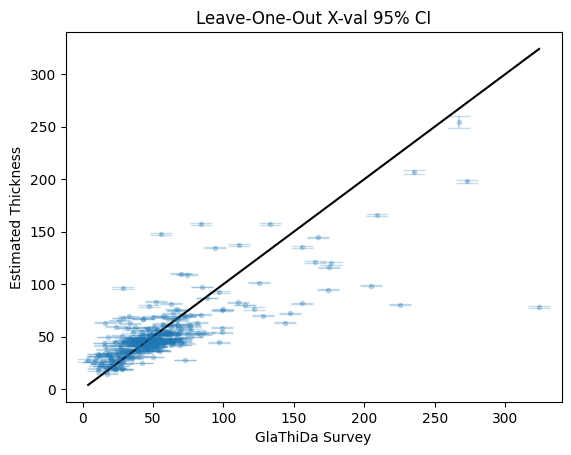

In [11]:
#### Calculate 95% confidence intervals ####
X = np.mean(df[cols], axis = 1)
se = np.std(df[cols], axis = 1) / np.sqrt(len(cols))

df['LCI'] = X - (1.96 * se)
df['UCI'] = X + (1.96 * se)

lb = df['LCI'] / 1e3 * df['Area'] / 1e3
ub = df['UCI'] / 1e3 * df['Area'] / 1e3

x = df['Thickness']
# y = np.mean(dfci, axis = 1)
# y = df['we']
y = np.mean(df[cols],axis = 1)
plt.errorbar(
    x,y,yerr = df['UCI'] - df['LCI'],
        alpha = 0.25,
#     label = 'Estimates $\hat{\mu}(x)$',
    linestyle = 'None',
    marker = '.',
    capsize = 8,
    color = '#1f77b4',
)

plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    '-k'
)

plt.ylabel('Estimated Thickness')
plt.xlabel('GlaThiDa Survey')
plt.title('Leave-One-Out X-val 95% CI')
# plt.xscale('log')
# plt.yscale('log')

Text(0, 0.5, 'Left Out Glacier B Estimates')

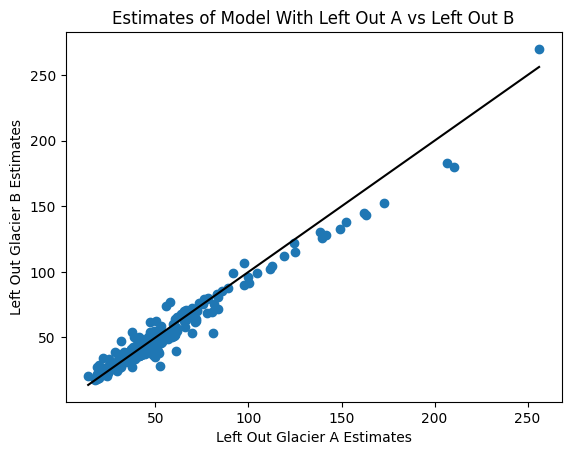

In [12]:
x = df[cols].T.loc[157]
y = df[cols].T.loc[111]
plt.plot(x,y,'o')
plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    'k-'
)
plt.title('Estimates of Model With Left Out A vs Left Out B')
plt.xlabel('Left Out Glacier A Estimates')
plt.ylabel('Left Out Glacier B Estimates')

In [13]:
conditions = [cor2 > 0]
def glac_finder(conditions):

    where = np.where(conditions)
    a = where[1]
    b = where[2]

    t = np.zeros(shape=(len(a), 2))

    combs = [[]]
    for i in tqdm(range(len(a))):
        x = a[i]
        y = b[i]
        if [x,y] in combs:
            continue
        z = np.array([x,y])
        t[i] = z   
        combs.append([y,x])
    t = t[np.where(t[:,0] != t[:,1])]
    return t

def find_diffs(t,obj):
    feat_list = ['Correlation','Distance','Area','Lmax','Slope','Zmin','index1','index2']
    diffs = np.empty(shape = (0,len(feat_list)))
    for i in tqdm(range(len(t))):
        j = int(t[i][0])
        k = int(t[i][1])

        x = df.iloc[j]
        y = df.iloc[k]
        z = np.empty(shape = (len(feat_list),))

        for l,feat in enumerate(feat_list):
            if feat == 'Correlation':
                z[l] = obj[int(t[i][0]),int(t[i][1])]
            if feat == 'Distance':
                z[l] = geopy.distance.geodesic(
                    (x['CenLat'],x['CenLon']),
                    (y['CenLat'],y['CenLon'])
                ).kilometers
            if feat == 'index1':
                z[l] = j
            if feat == 'index2':
                z[l] = k
            if (feat != 'Correlation' and 
                feat != 'Distance' and 
                feat != 'index1' and 
                feat != 'index2'):
                z[l] = abs(x[feat] - y[feat])
        z = np.expand_dims(z,0)
        diffs = np.concatenate((diffs,z),axis = 0)

    diffs = pd.DataFrame(diffs)

    diffs = diffs.rename(columns = {
        0:'Correlation',1:'Distance (km)',2:'Area',
        3:'Lmax',4:'Slope',5:'Zmin',6:'index1',7:'index2'
    })
    diffs = diffs.sort_values('Correlation')
    return diffs

100%|██████████| 544/544 [00:00<00:00, 203287.72it/s]


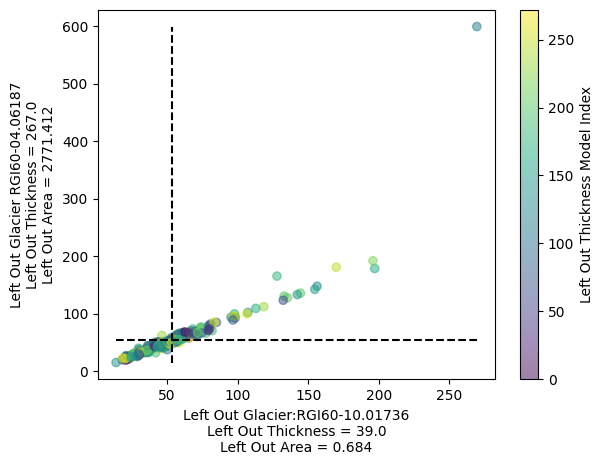

In [14]:
conditions = [cor1 < 0.95]
t = glac_finder(conditions)
i = np.random.randint(0, len(t))

j = int(t[i][0])
k = int(t[i][1])

x = df[cols].T.iloc[j]
y = df[cols].T.iloc[k]
z = df[cols].index
plt.scatter(x,y,c = z,alpha = 0.5)

# model = np.poly1d(np.polyfit(x, y, 1))
# plt.plot(x,model(x),'-r')
plt.xlabel('Left Out Glacier:' + df['RGIId'].iloc[j] + 
          '\nLeft Out Thickness = ' + str(df['Thickness'].iloc[j]) +
          '\nLeft Out Area = ' + str(df['Area'].iloc[j]))
plt.ylabel('Left Out Glacier ' + df['RGIId'].iloc[k] + 
           '\nLeft Out Thickness = ' + str(df['Thickness'].iloc[k]) +
           '\nLeft Out Area = ' + str(df['Area'].iloc[k]))
plt.colorbar(label = 'Left Out Thickness Model Index')
plt.plot(
    (x.mean(),x.mean()),
    (y.min(),y.max()),
    '--k'
)
plt.plot(
    (x.min(),x.max()),
    (y.mean(),y.mean()),
    '--k'
    
)
# plt.axis('square')

100%|██████████| 36856/36856 [00:35<00:00, 1025.27it/s]


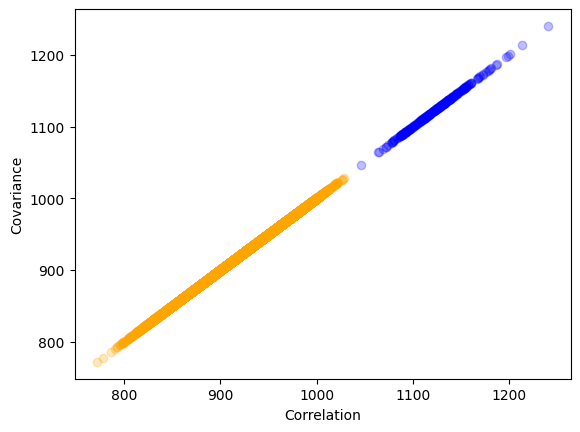

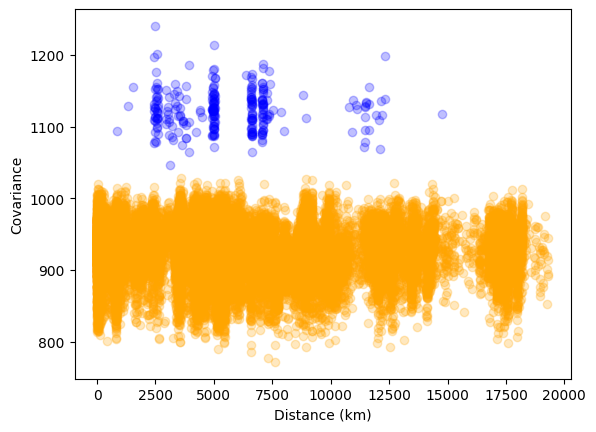

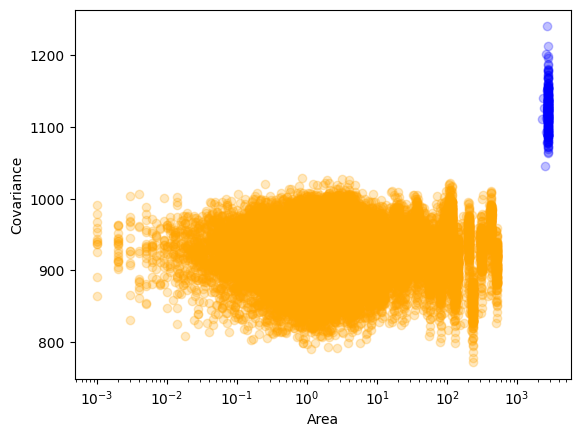

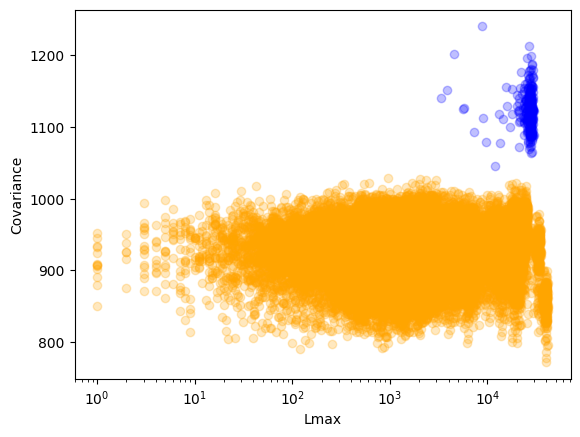

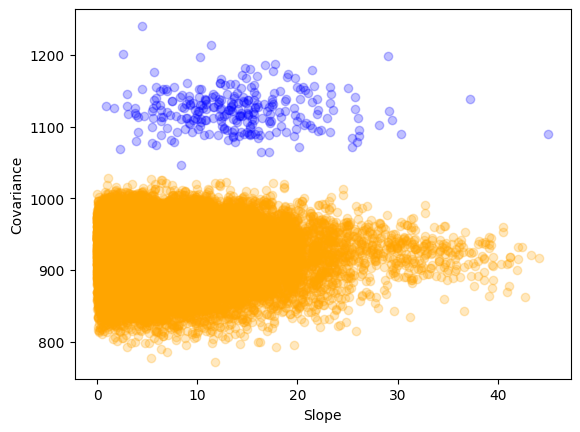

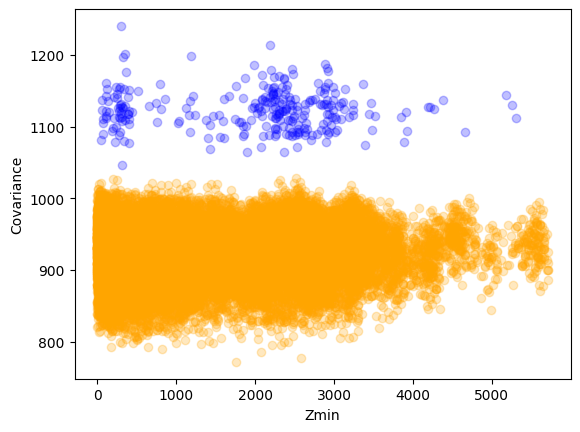

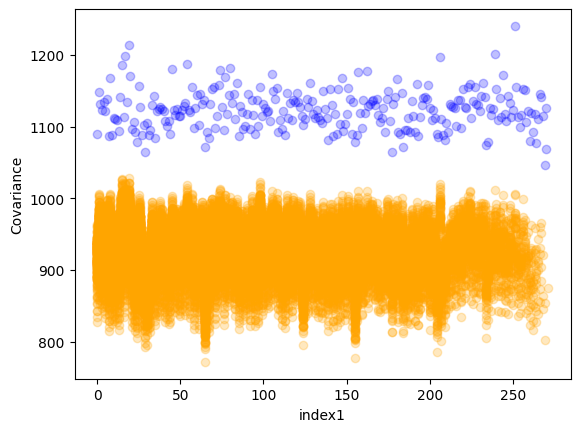

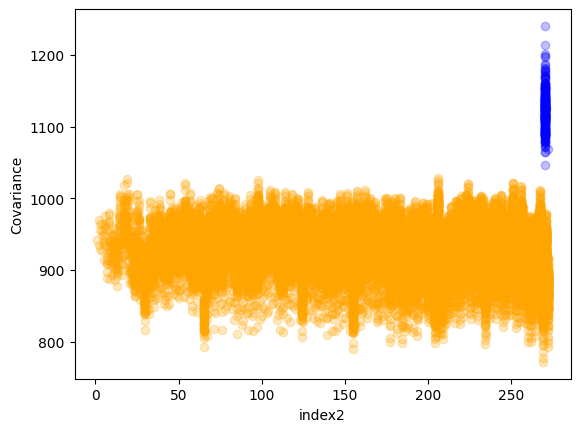

In [15]:
obj = cov1
conditions = [obj > 1045]
t = glac_finder(conditions)
diffs1 = find_diffs(t,obj)

conditions = [obj < 1045]
t = glac_finder(conditions)
diffs2 = find_diffs(t,obj)

feat_list = list(diffs1)

for feat in feat_list:
    plt.scatter(
        diffs1[feat], diffs1['Correlation'], 
        alpha = 0.25,color = 'blue',
        label = 'Corr > 0'
    )
    plt.scatter(
        diffs2[feat],diffs2['Correlation'],
        alpha = 0.25,color = 'orange',
        label = 'Corr < 0'
    )
    if feat == 'Area' or feat == 'Lmax':
        plt.xscale('log')
    plt.xlabel(feat)
    plt.ylabel('Covariance')
    plt.show()

100%|██████████| 272/272 [00:00<00:00, 1233.96it/s]


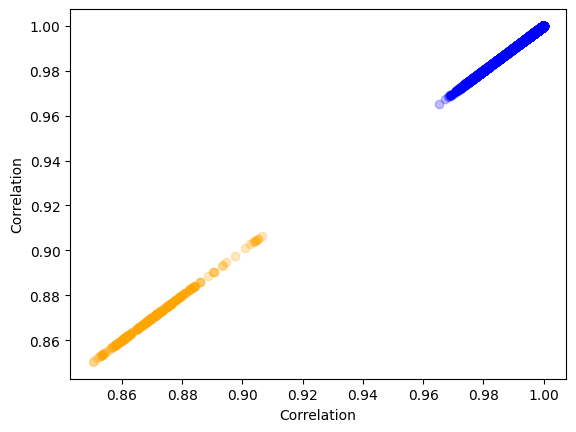

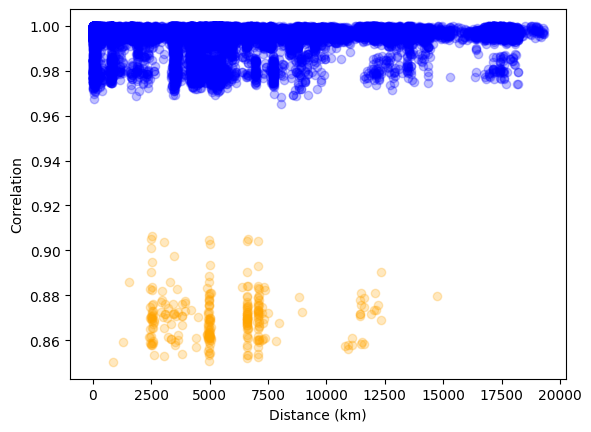

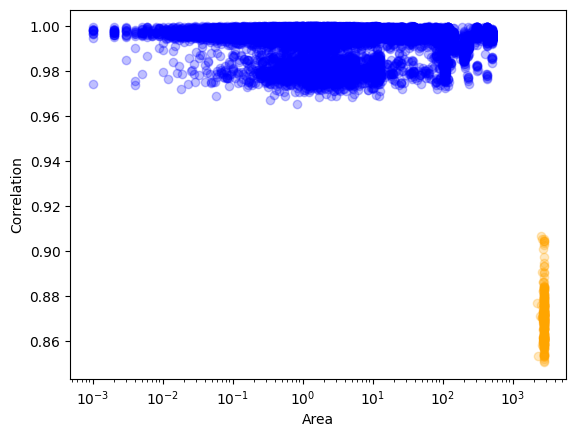

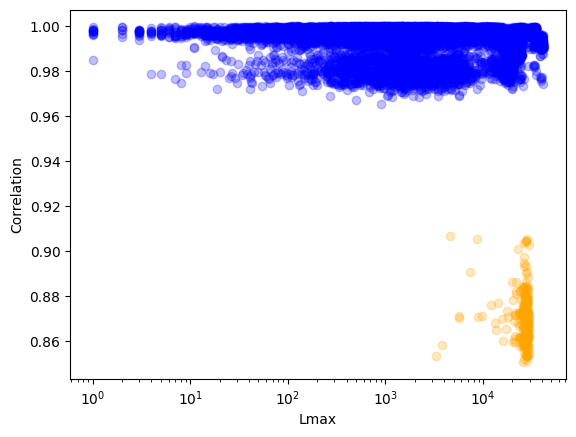

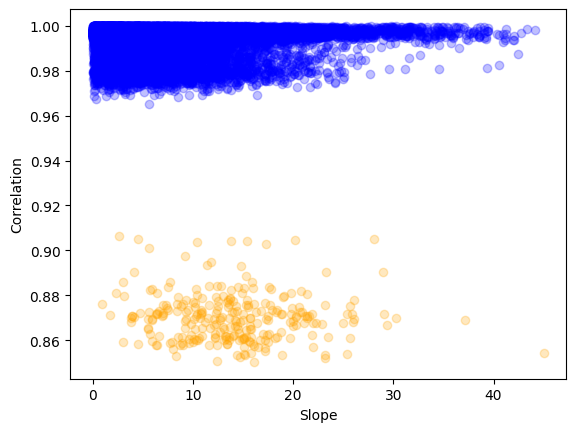

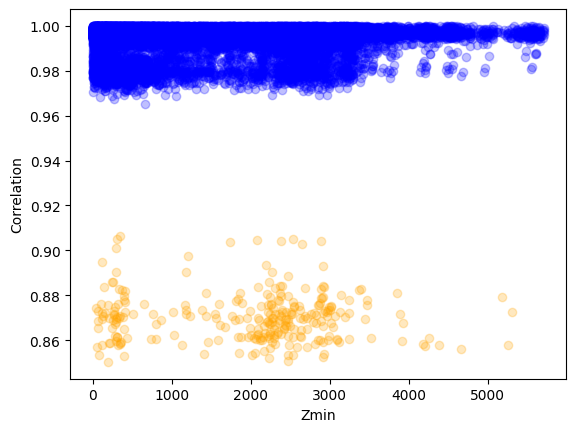

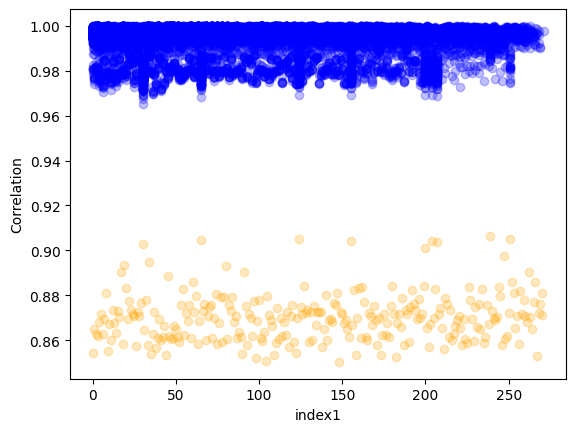

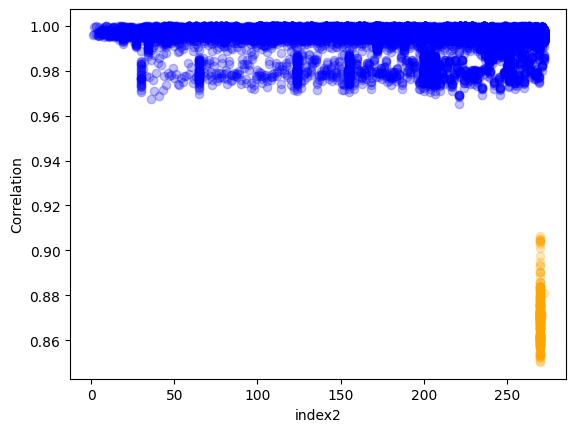

In [16]:
obj = cor1
conditions = [obj > 0.94]
t = glac_finder(conditions)
diffs1 = find_diffs(t,obj)

conditions = [obj < 0.94]
t = glac_finder(conditions)
diffs2 = find_diffs(t,obj)

feat_list = list(diffs1)

for feat in feat_list:
    plt.scatter(
        diffs1[feat], diffs1['Correlation'], 
        alpha = 0.25,color = 'blue',
        label = 'Corr > 0'
    )
    plt.scatter(
        diffs2[feat],diffs2['Correlation'],
        alpha = 0.25,color = 'orange',
        label = 'Corr < 0'
    )
    if feat == 'Area' or feat == 'Lmax':
        plt.xscale('log')
    plt.xlabel(feat)
    plt.ylabel('Correlation')
    plt.show()

In [17]:
from scipy.sparse.linalg import eigs

In [18]:
L,Q=eigs(cov2,10)

In [19]:
Q

array([[ 0.01663211+0.j,  0.14282192+0.j,  0.29231074+0.j, ...,
        -0.07217627+0.j,  0.00544705+0.j,  0.00508304+0.j],
       [ 0.02865681+0.j, -0.03384145+0.j,  0.0197587 +0.j, ...,
        -0.03837342+0.j,  0.00726008+0.j, -0.00222285+0.j],
       [ 0.0010806 +0.j,  0.01051127+0.j,  0.01840872+0.j, ...,
         0.011655  +0.j,  0.00479986+0.j, -0.0895206 +0.j],
       ...,
       [ 0.86606553+0.j,  0.3654706 +0.j, -0.245802  +0.j, ...,
         0.07976172+0.j, -0.03044096+0.j, -0.03954046+0.j],
       [-0.06178976+0.j,  0.13322687+0.j, -0.24557308+0.j, ...,
        -0.1458777 +0.j, -0.09502183+0.j,  0.1577174 +0.j],
       [-0.02665076+0.j,  0.12657022+0.j,  0.13754749+0.j, ...,
         0.0241693 +0.j, -0.15495573+0.j,  0.05583622+0.j]])

[0.38213278+0.j 0.27129038+0.j 0.11078777+0.j 0.07102803+0.j
 0.05845505+0.j 0.03251148+0.j 0.02585674+0.j 0.02107309+0.j
 0.01619705+0.j 0.01066763+0.j]


/home/sa42/miniconda3/envs/new_kernel/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/sa42/miniconda3/envs/new_kernel/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


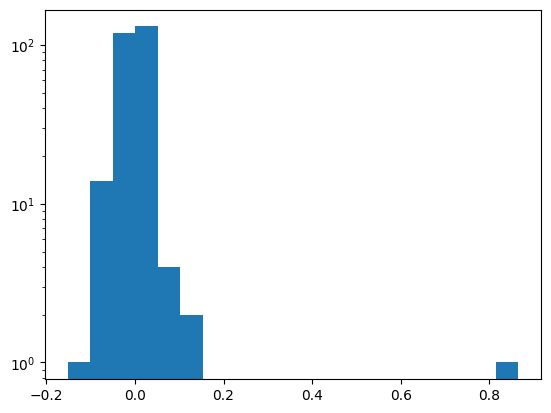

In [20]:
print(L/sum(L))

plt.hist((Q[:,0]),20)
plt.yscale('log')



In [21]:
sum(np.abs(Q[:,0]) > 0.01)/340

0.49411764705882355

(240.0, 273.0)

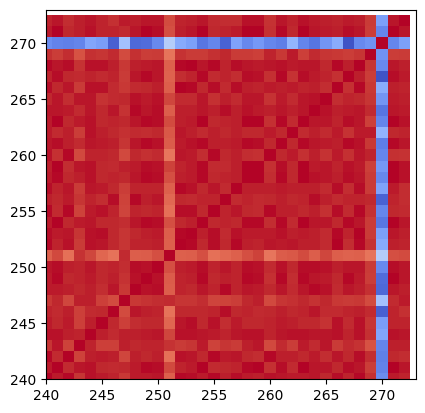

In [22]:
plt.imshow(cor1,vmin=np.min(cor1),vmax=np.max(cor1),cmap='coolwarm')
plt.xlim([240,273])
plt.ylim([240,273])

In [23]:
cols[270]

115

In [24]:
df.T.loc[115]

267     25.211826
154      30.21879
257     27.831625
238      35.15921
122      33.64513
          ...    
34      73.683739
165    178.343964
115    599.205688
218    191.781494
39       70.50222
Name: 115, Length: 273, dtype: object

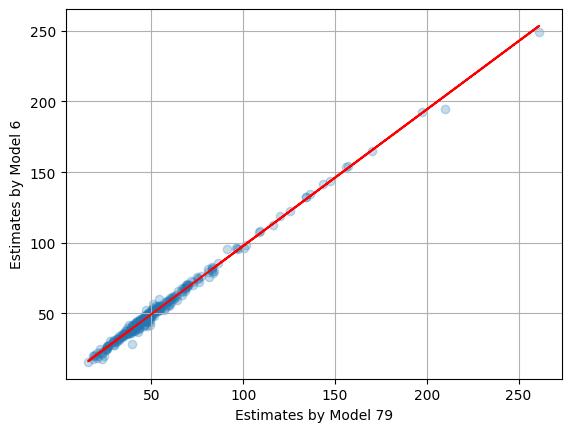

In [25]:
j = np.random.randint(0, 272)
# j = 157
x = df[j]
i = np.random.randint(0, 272)
# i = 57
y = df[i]
plt.scatter(x,y,alpha = 0.25)
# plt.plot(
#     (10,300),
#     (10,300),
#     'k-'
# )

model = np.poly1d(np.polyfit(x, y, 1))


# plt.axis('square')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Estimates by Model ' + str(j))
plt.ylabel('Estimates by Model ' + str(i))
plt.grid()
plt.plot(x,model(x),'-r')
plt.show()

# plt.imshow(cov2,cmap = 'coolwarm',vmin =np.min(cov2), vmax = np.max(cov2))

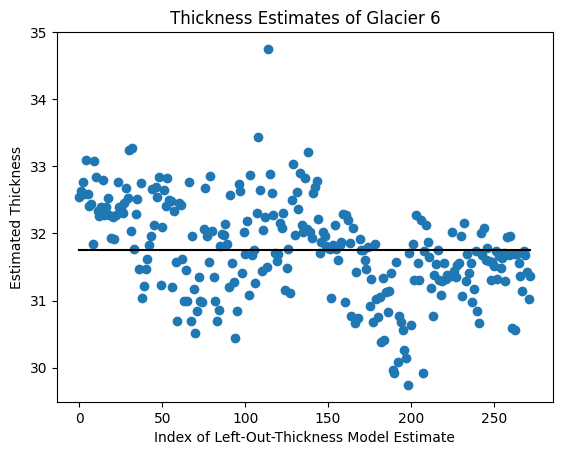

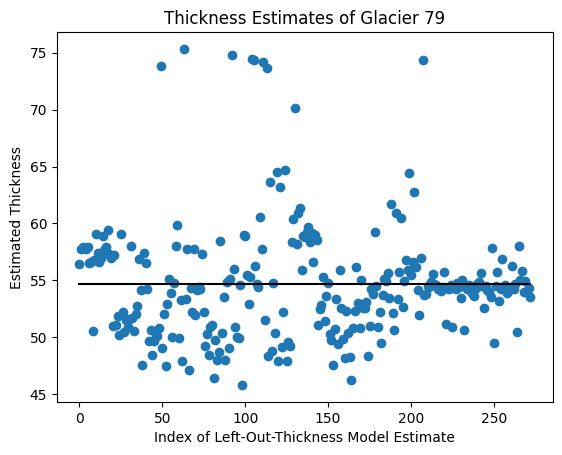

In [26]:
plt.plot((df[cols].iloc[i]),'o')
plt.title('Thickness Estimates of Glacier ' + str(i))
plt.xlabel('Index of Left-Out-Thickness Model Estimate')
plt.ylabel('Estimated Thickness')
plt.plot(
    (0,df.index.sort_values()[-1]),
    (np.mean(df[cols].iloc[i]), np.mean(df[cols].iloc[i])),
    '-k'
)

# plt.plot(
#     (0,340),
#     (df['Thickness'].iloc[i], df['Thickness'].iloc[i]),
#     '-.k'
# )

plt.show()
plt.plot((df[cols].iloc[j]),'o')
plt.title('Thickness Estimates of Glacier ' + str(j))
plt.xlabel('Index of Left-Out-Thickness Model Estimate')
plt.plot(
    (0,df.index.sort_values()[-1]),
    (np.mean(df[cols].iloc[j]), np.mean(df[cols].iloc[j])),
    '-k'
)
# plt.plot(
#     (0,340),
#     (df['Thickness'].iloc[j], df['Thickness'].iloc[j]),
#     '-.k'
# )
plt.ylabel('Estimated Thickness')
plt.show()

In [27]:
# plt.plot(thickness_estimates[10,:],thickness_estimates[9,:],'o')
# plt.xlabel('Thickness estimates for Glacier A')
# plt.ylabel('Thickness estimates for Glacier B')
# plt.axis('square')

In [28]:
np.mean(df[cols],axis = 1)

267     27.290054
154     25.866758
257     27.427725
238     30.997835
122     33.253056
          ...    
34      80.291458
165    207.129303
115    254.446060
218    197.827332
39      78.019135
Length: 273, dtype: float32

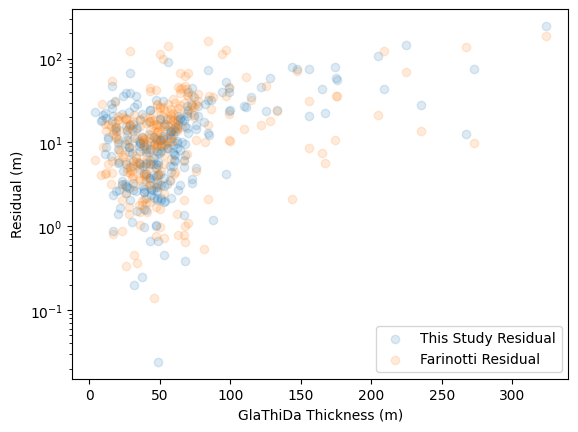

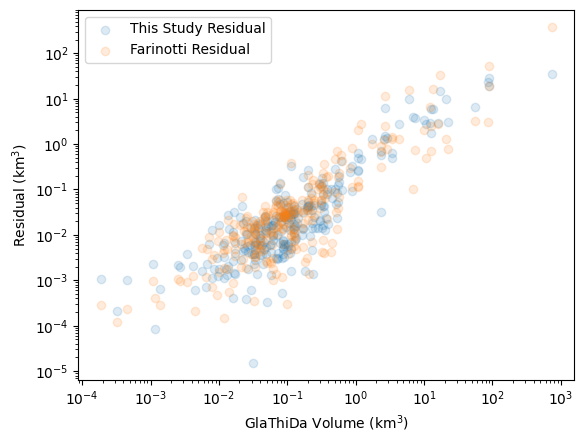

In [29]:
x = df['Thickness']
y = np.mean(df[cols],axis = 1)
z = df['FMT']
plt.scatter(
    x,abs(y-x),alpha = 0.15,label = 'This Study Residual'
)
plt.scatter(
    x,abs(z-x),alpha = 0.15,label = 'Farinotti Residual'
)
plt.plot(
    (x.min(),x.max()),
    (0,0),'k--'
)
plt.xlabel('GlaThiDa Thickness (m)')
plt.ylabel('Residual (m)')
plt.legend()
plt.yscale('log')
# plt.xscale('log')
plt.show()

x = (df['Thickness'] / 1e3) * df['Area']
y = (np.mean(df[cols],axis = 1) / 1e3) * df['Area']
z = (df['FMT'] / 1e3) * df['Area']
plt.scatter(
    x,abs(y-x),alpha = 0.15,label = 'This Study Residual'
)
plt.scatter(
    x,abs(z-x),alpha = 0.15,label = 'Farinotti Residual'
)
plt.plot(
    (x.min(),x.max()),
    (0,0),'k--'
)
plt.xlabel('GlaThiDa Volume (km$^3$)')
plt.ylabel('Residual (km$^3$)')
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [30]:
np.mean(abs(y-x))

0.7693042565164223

In [31]:
np.std(abs(y-x))

3.551196897420599

In [32]:
np.mean(abs(df['FMT']-x))

58.049513695970695

In [33]:
np.std(abs(df['FMT']-x))

45.042734653753584

In [34]:
df['res'] = y - df['Thickness'] 

df[abs(df['res']) >= 100]

/tmp/ipykernel_3824550/3340318367.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['res'] = y - df['Thickness']


RGIId     CenLat      CenLon  Slope  Zmin  Zmed  Zmax      Area   
190  RGI60-13.18096  39.609699   71.569862   10.0  3648  4202  4895    21.345  \
103  RGI60-05.11186  65.695700  -37.803200   11.3   159   648   983    20.154   
80   RGI60-17.13785 -33.403600  -69.822000   10.0  4255  5492  5885     7.233   
237  RGI60-07.00229  77.472200   14.996800    9.1   160   490   889    27.098   
76   RGI60-08.00966  61.542000    8.454000    7.5  1639  1880  2254     8.563   
150  RGI60-07.00465  78.545200   13.895300    8.1    58   432  1018   119.079   
37   RGI60-09.01061  81.371400   59.073800   24.4     0   155   281    48.695   
203  RGI60-01.00570  63.281000 -145.427000   14.0  1162  1858  2438    17.567   
255  RGI60-09.00856  81.614000   63.010600   17.1     1   211   358    81.342   
66   RGI60-07.00482  78.664100   13.109500    7.5    58   448   897    82.410   
232  RGI60-07.00240  77.074800   15.579900    7.4   104   353   686    64.211   
141  RGI60-07.00529  78.748100   13.891100    7.7   107   515   954   132.743   
241  RGI60-09.00990  80.998800   61.193900   16.5    14   250   428   121.393   
170  RGI60-07.00511  78.767800   12.191900    9.1     2   439   974    57.860   
178  RGI60-09.00697  80.580500   50.433100   13.6     0   263   421   512.015   
91   RGI60-08.01657  66.657000   13.853000    6.6   148  1186  1568    36.049   
244  RGI60-09.00807  80.857700   64.662900   11.9    12   176   505   432.494   
34   RGI60-08.01127  61.711000    7.025000    8.3   522  1711  1940    19.002   
165  RGI60-01.00037  63.469173 -146.528168   12.0   722  1841  3081   234.583   
115  RGI60-04.06187  70.021400  -73.057500    3.6   403   860  1117  2771.412   
218  RGI60-07.00301  77.285700   14.994900    5.3   135   407   917   312.535   
39   RGI60-17.12601 -38.983000  -71.531700    5.9  1833  2098  2265     5.273   

     Aspect   Lmax  Thickness         GLIMSId   BgnDate   EndDate  O1Region   
190      27   8572      110.0  G071570E39610N  20000916  -9999999        13  \
103     261   8083      115.0  G322197E65696N  20020727  -9999999         5   
80      298   8109      122.0  G290178E33404S  20009999  20030531        17   
237     358  12765      125.0  G014997E77472N  20080901  -9999999         7   
76      107   5017      128.0  G008454E61542N  20030809  -9999999         8   
150     118  26052      133.0  G013895E78545N  20070901  -9999999         7   
37       43   6158      144.0  G059074E81371N  20040715  -9999999         9   
203     172   8639      147.0  G214573E63281N  20090804  -9999999         1   
255     206   9388      156.0  G063011E81614N  20040715  -9999999         9   
66      151  20189      156.0  G013110E78664N  20070901  -9999999         7   
232     136  16606      165.0  G015580E77075N  20080901  -9999999         7   
141     104  22508      167.0  G013891E78748N  20070901  -9999999         7   
241     117  11787      174.0  G061194E80999N  20010619  -9999999         9   
170     325  16274      175.0  G012192E78768N  20070901  -9999999         7   
178     143  15512      176.0  G050433E80581N  20060702  20060719         9   
91      330   9888      205.0  G013853E66657N  19990907  -9999999         8   
244     111  26546      209.0  G064663E80858N  20010619  -9999999         9   
34      347   6666      225.0  G007025E61711N  20060916  -9999999         8   
165      30  41911      235.0  G213472E63469N  20090703  -9999999         1   
115      51  29873      267.0  G286943E70021N  20020802  20020905         4   
218     229  35580      273.0  G014995E77286N  20080901  -9999999         7   
39      232   3177      324.0  G288468E38983S  20009999  20030531        17   

     O2Region  Status  Connect  Form  TermType  Surging  Linkages   
190         1       0        0     0         0        2         1  \
103         1       0        0     0         0        9         1   
80          2       0        0     0         0        9         9   
237         1       0        0     0         0        0 

(array([  1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   2.,   4.,   5., 249.,   4.,   0.,   2.,   0.,
          1.,   0.,   1.]),
 array([-34.79214144, -32.79779884, -30.80345623, -28.80911362,
        -26.81477101, -24.8204284 , -22.82608579, -20.83174318,
        -18.83740057, -16.84305796, -14.84871535, -12.85437274,
        -10.86003013,  -8.86568752,  -6.87134491,  -4.8770023 ,
         -2.88265969,  -0.88831708,   1.10602553,   3.10036814,
          5.09471075,   7.08905336,   9.08339597,  11.07773857,
         13.07208118,  15.06642379]),
 <BarContainer object of 25 artists>)

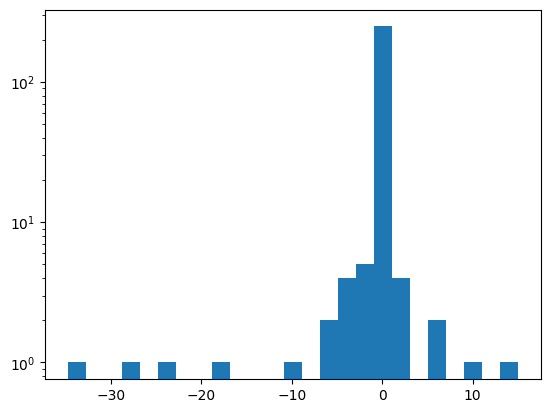

In [35]:
plt.hist(y-x,bins = 25,log = True)

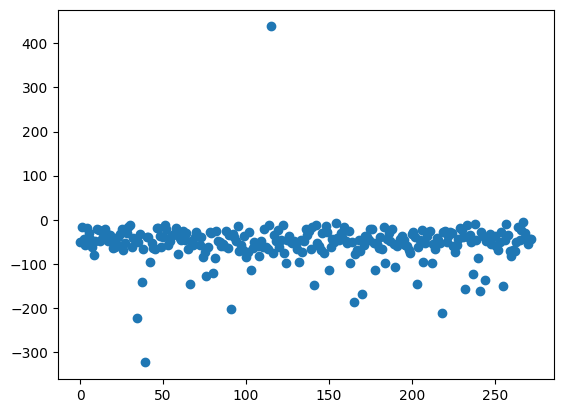

In [36]:
plt.scatter(
    df.index, df['res']
)
# plt.xscale('log')

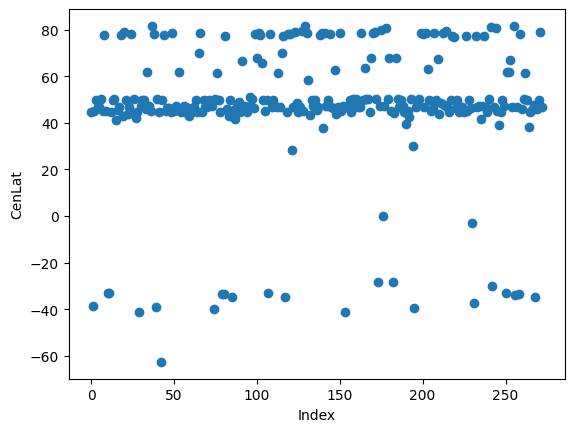

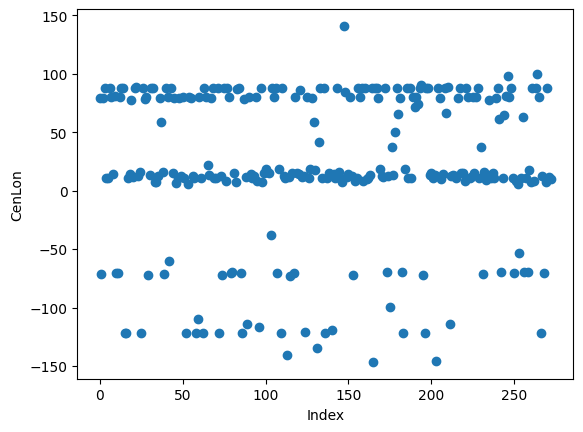

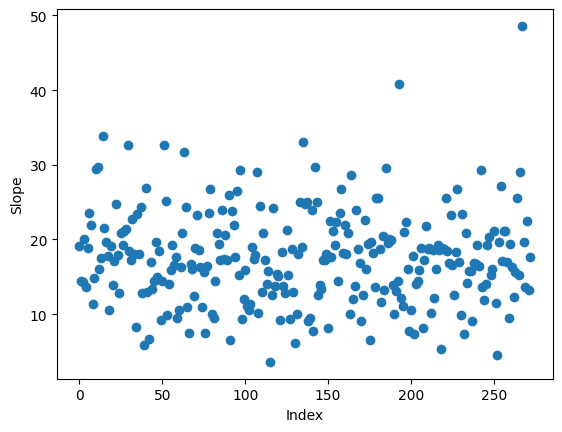

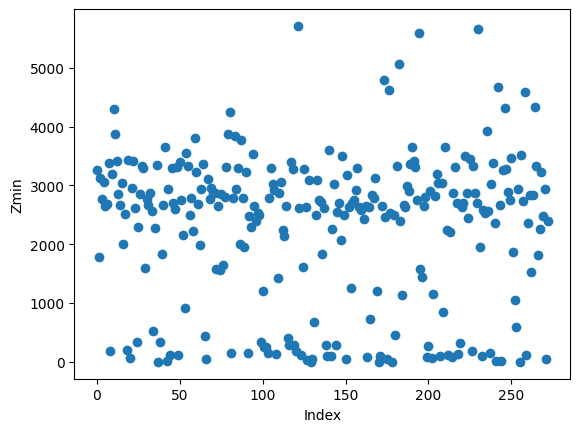

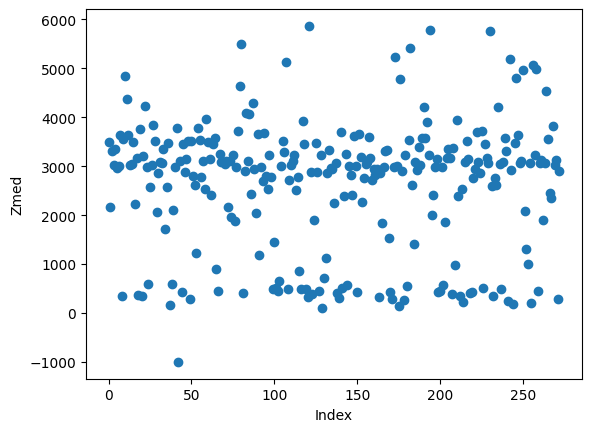

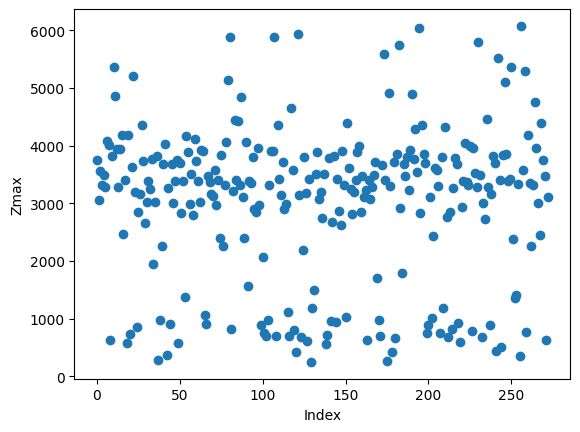

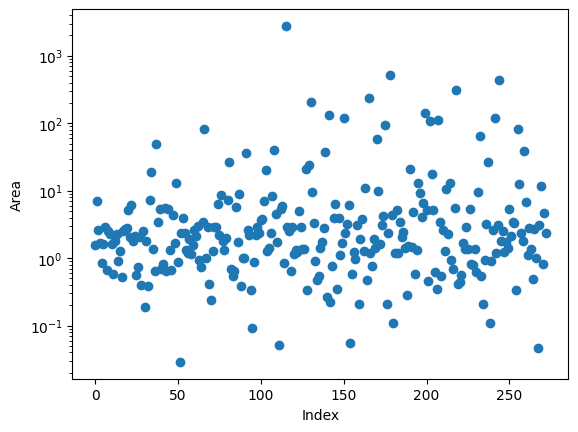

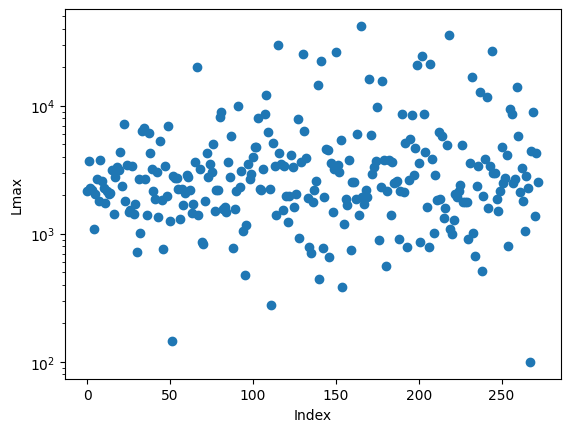

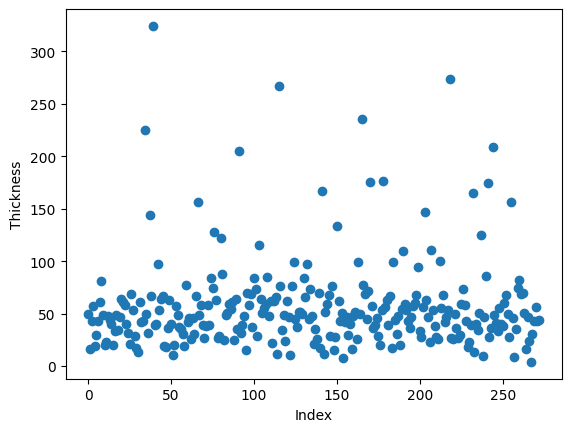

In [37]:
feat_list = ['CenLat', 'CenLon','Slope','Zmin','Zmed','Zmax','Area','Lmax','Thickness']

for feature in feat_list:
    plt.scatter(
        df.index,
        df[feature]
    )
    plt.xlabel('Index')
    plt.ylabel(feature)
    if feature == 'Area' or feature == 'Lmax':
        plt.yscale('log')
    plt.show()



In [38]:
cov = pd.DataFrame(cov1)
# cor = pd.DataFrame(cor)

# bad_indexes = cov[cov[cols] == 0].dropna(axis = 0).index
# cov_d = cov.drop(bad_indexes)
# cor_d = cor.drop(bad_indexes)

# cov_d = cov_d.reset_index().drop('index',axis = 1)
# cor_d = cor_d.reset_index().drop('index',axis = 1)

# dftr = dft.drop(bad_indexes)
# dftr = dftr.reset_index().drop('index',axis = 1)

# dfpd = df[cols].T.copy()
# dfpd = dfpd.drop(bad_indexes)
# dfpd = dfpd.reset_index().drop('index', axis = 1)

In [39]:
# identify columns that have one estimate for all glaciers.
bad_models = df[cols].T[df.T.duplicated()].index
bad_models

/tmp/ipykernel_3824550/1117204460.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bad_models = df[cols].T[df.T.duplicated()].index


Index([], dtype='object')

In [40]:
cols = list(filter(lambda a: a not in bad_models.to_list(), cols))
df = df.drop(bad_models)

100%|██████████| 273/273 [00:03<00:00, 70.98it/s] 


<Axes: ylabel='Left-Out Index'>

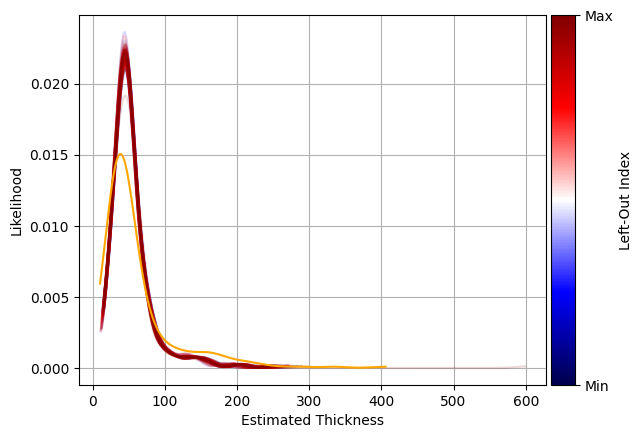

In [41]:
n = 0
p = plt.get_cmap('seismic')
for i in tqdm(
    df.index,
):
    x = df[cols].T.loc[i]
    z = normx(x,norm)
    x_eval = np.linspace(z.min(),z.max(),500)

    kde = st.gaussian_kde(np.array(z))
    plt.plot(
        x_eval, kde(x_eval), '-',alpha = 0.15,
        c = p(n/(len(df) - 1))
    )
    n = n + 1
x = df['FMT']
z = normx(x,norm)
x_eval = np.linspace(z.min(),z.max(),500)
kde = st.gaussian_kde(np.array(z))
plt.plot(
    x_eval, kde(x_eval), '-',alpha = 1,
    c = 'orange'
)
plt.grid()

# plt.xscale('symlog')
plt.ylabel('Likelihood')
if norm == True:
    plt.xlabel('Normalized Estimated Thickness')
if norm == False:
    plt.xlabel('Estimated Thickness')
# plt.xscale('log')
# plt.title('Leave-One-Out Thickness PDF  -- sorted by ' + feat + ' ' +  order)
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(
    ax_cb, cmap=p, orientation='vertical',
    ticklocation = 'auto',ticks = [],
    label = 'Left-Out Index'
)
cb1.set_ticks(ticks = (0,1),labels = ['Min','Max'])
# cb1.set_label('Thickness',x = -0.07)
plt.gcf().add_axes(ax_cb)
#     plt.show()


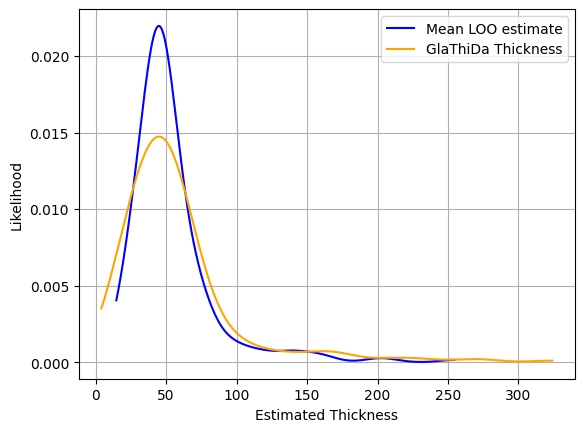

In [42]:
# check the mean estimate.

x = np.mean(df[cols],axis = 1)
z = normx(x,norm)
x_eval = np.linspace(z.min(),z.max(),500)
kde = st.gaussian_kde(np.array(z))
plt.plot(
    x_eval, kde(x_eval), '-',alpha = 1,
    c = 'blue',label = 'Mean LOO estimate'
)


x = df['Thickness']
z = normx(x,norm)
x_eval = np.linspace(z.min(),z.max(),500)
kde = st.gaussian_kde(np.array(z))
plt.plot(
    x_eval, kde(x_eval), '-',alpha = 1,
    c = 'orange',label = 'GlaThiDa Thickness'
)

# x = df['FMT']
# z = normx(x,norm)
# x_eval = np.linspace(z.min(),z.max(),500)
# kde = st.gaussian_kde(np.array(z))
# plt.plot(
#     x_eval, kde(x_eval), '-',alpha = 1,
#     c = 'red',label = 'Farinotti Thickness'
# )
plt.grid()
plt.legend()
# plt.title('Leave-One-Out Mean Thickness PDF -- sorted by ' + feat + ' ' +  order)

# plt.xscale('symlog')
plt.ylabel('Likelihood')
if norm == True:
    plt.xlabel('Normalized Estimated Thickness')
if norm == False:
    plt.xlabel('Estimated Thickness')
# plt.title('Leave-One-Out Thickness PDF')
# divider = make_axes_locatable(plt.gca())
# ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
# cb1 = mpl.colorbar.ColorbarBase(
#     ax_cb, cmap=p, orientation='vertical',
#     ticklocation = 'auto',ticks = [],
#     label = 'Left-Out Thickness'
# )
# cb1.set_ticks(ticks = (0,1),labels = ['Min','Max'])
# cb1.set_label('Thickness',x = -0.07)
# plt.gcf().add_axes(ax_cb)

#     plt.show()
# plt.xscale('log')

Text(0, 0.5, 'Estimated Volume')

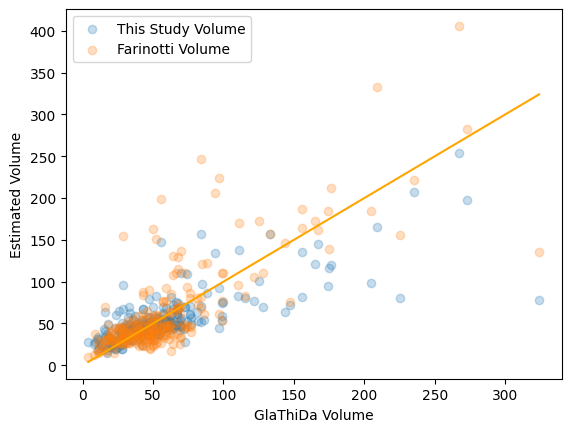

In [43]:
x = df['Thickness']
y = np.mean(df[cols],axis = 1)
z = df['FMT'] 
plt.scatter(
    x,y,alpha = 0.25,label = 'This Study Volume'
)
plt.scatter(
    x,z,alpha = 0.25,label = 'Farinotti Volume'
)
plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    c = 'orange'    
)
plt.legend()
plt.xlabel('GlaThiDa Volume')
plt.ylabel('Estimated Volume')
# plt.xscale('log')
# plt.yscale('log')

100%|██████████| 273/273 [00:01<00:00, 149.94it/s]


<Axes: ylabel='Left-Out Index'>

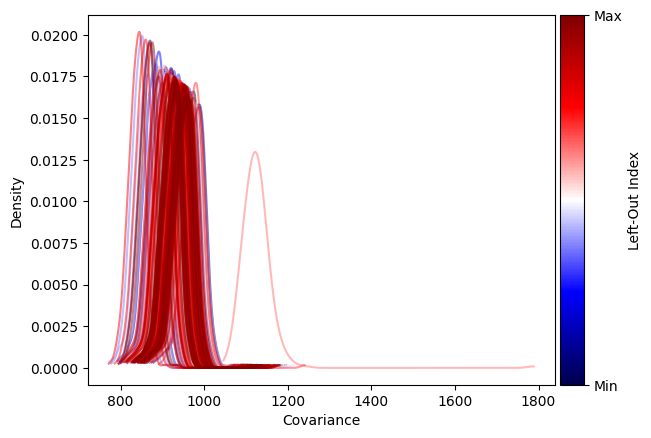

In [44]:
p = plt.get_cmap('seismic')
n = 0
for i in tqdm(
    df.index,
#     dftr.sort_values('Thickness',ascending = True).reset_index().index
):
#     print(dft['Thickness'].loc[i])

    
    x =cov.loc[i] 
    z = normx(x,norm)

    x_eval = np.linspace(z.min(),z.max(),500)

    kde = st.gaussian_kde(np.array(z))
    plt.plot(
        x_eval, kde(x_eval), '-',alpha = 0.5,
        c = p(n/(len(df)))
    )
    n = n + 1
#     c = p(n/(len(pos) - 1))
# plt.ylim(0,0.2)
# plt.yscale('log')
# plt.xscale('symlog')
plt.ylabel('Density')
if norm == True:
    plt.xlabel('Normalized Covariance')
if norm == False:
    plt.xlabel('Covariance')
# plt.title('Leave-One-Out Covariance PDF -- sorted by ' + feat + ' ' +  order )
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(
    ax_cb, cmap=p, orientation='vertical',
    ticklocation = 'auto',ticks = [],
    label = 'Left-Out Index'
)
cb1.set_ticks(ticks = (0,1),labels = ['Min','Max'])
# cb1.set_label('Thickness',x = -0.07)
plt.gcf().add_axes(ax_cb)

#     plt.show()
